In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
%matplotlib inline

In [2]:
rawData = pd.read_csv('ED_COVID19_dashboard.csv')

In [3]:
# identify covid cases
rawData.loc[(rawData.ED_LAB_COVID19=="Positive") | (rawData.ED_LAB_COVID19=="Presumptive Positive"), 'ED_LAB_COVID19']  ="Detected"   
rawData.loc[(rawData.ED_LAB_COVID19=="Not Detected"), 'ED_LAB_COVID19'] ="Not detected"  
rawData = rawData.loc[(rawData.ED_LAB_COVID19 == 'Detected') | (rawData.ED_LAB_COVID19 == 'Not detected')]
rawData['covid'] = rawData.ED_LAB_COVID19=="Detected"
rawData = rawData.loc[rawData.covid]

In [4]:
# clean outcomes
rawData.loc[(rawData.ED_PM_EXPIRED_IN_ED_YN=="Y"), 'ED_ADMIT_TO_ICU_YN'] = 1
rawData['icu'] = rawData.ED_ADMIT_TO_ICU_YN=="Y"


In [5]:
rawData.ED_LAB_COVID19.value_counts()

Detected    301
Name: ED_LAB_COVID19, dtype: int64

In [6]:
pd.crosstab(rawData.covid, rawData.icu, dropna=False )

icu,False,True
covid,,
True,260,41


In [7]:
# truncate high low lab values and convert to floats
rawData.ED_LAB_CRP.replace('<0.2', 0.1, inplace=True)

rawData.ED_LAB_DDIMER.replace('<0.17', 0.085, inplace=True)
rawData.ED_LAB_DDIMER.replace('>35.00', 40, inplace=True)

rawData.ED_LAB_FERRITIN.replace('>16500.0', 17000, inplace=True)
rawData.ED_LAB_FERRITIN.replace('>1650.0', 17000, inplace=True)

rawData.ED_LAB_IL6.replace('>3670.0', 4100, inplace=True)
rawData.ED_LAB_IL6.replace('>4060.0', 4100, inplace=True)

rawData.ED_LAB_CMP_ALT.replace('<8', 4, inplace=True)

rawData.ED_LAB_HSTROP0.replace('<6', 3, inplace=True)
rawData.ED_LAB_HSTROP2.replace('<6', 3, inplace=True)

rawData.ED_LAB_CBC_PLT.replace('<2', 1, inplace=True)
rawData.ED_LAB_CMP_CR.replace('SEE BELOW', np.nan, inplace=True)
rawData.ED_LAB_CMP_CR.replace('<0.10', 0.005, inplace=True)

rawData.ED_LAB_CBC_HGB.replace('SEE BELOW', np.nan, inplace=True)
rawData.ED_LAB_VBG_LAC.replace('SEE BELOW', np.nan, inplace=True)


rawData.ED_LAB_CRP = rawData.ED_LAB_CRP.astype('float')
rawData.ED_LAB_DDIMER = rawData.ED_LAB_DDIMER.astype('float')
rawData.ED_LAB_FERRITIN = rawData.ED_LAB_FERRITIN.astype('float')
rawData.ED_LAB_IL6 = rawData.ED_LAB_IL6.astype('float')
rawData.ED_LAB_CMP_ALT = rawData.ED_LAB_CMP_ALT.astype('float')
rawData.ED_LAB_HSTROP0 = rawData.ED_LAB_HSTROP0.astype('float')
rawData.ED_LAB_HSTROP2 = rawData.ED_LAB_HSTROP2.astype('float')
rawData.ED_LAB_CBC_PLT = rawData.ED_LAB_CBC_PLT.astype('float')
rawData.ED_LAB_CMP_CR = rawData.ED_LAB_CMP_CR.astype('float')
rawData.ED_LAB_CBC_HGB =  rawData.ED_LAB_CBC_HGB.astype('float')
rawData.ED_LAB_VBG_LAC =  rawData.ED_LAB_VBG_LAC.astype('float')
rawData.ED_LAB_LDH =  rawData.ED_LAB_LDH.astype('float')
rawData.ED_LAB_CMP_ALB =  rawData.ED_LAB_CMP_ALB.astype('float')

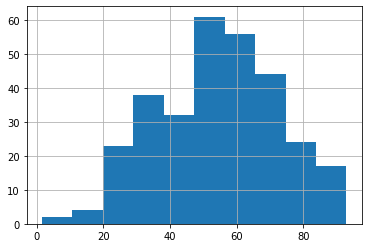

In [8]:
rawData.AGE_AT_VISIT_YRS.hist()

In [9]:
rawData.GENDER.value_counts()
rawData['female'] = rawData.GENDER=="F"

In [10]:
rawData['highFi02'] = rawData.TRIAGE_FIO2 > 50

In [11]:
rawData = rawData[['AGE_AT_VISIT_YRS', 'female', 'TRIAGE_SBP', 'TRIAGE_DBP', 'TRIAGE_HR', 'TRIAGE_TEMP',
                   'highFi02', 'ED_LAB_CRP', 'ED_LAB_DDIMER', 'ED_LAB_FERRITIN', 'ED_LAB_CBC_PLT', 'ED_LAB_CBC_LYM',
                   'ED_LAB_CMP_CR', 'ED_LAB_CMP_TBILI', 'ED_LAB_HSTROP0', 'ED_LAB_IL6', 'covid', 'icu',
                   'ED_LAB_CBC_HGB', 'ED_LAB_VBG_LAC', 'ED_LAB_LDH', 'ED_LAB_CMP_ALB']]

In [12]:
# impute missing lab and vitals values

import statsmodels.imputation.mice as mice

def ols_formula(df, dependent_var):
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    fml = ''
    for col in df_columns:
        fml = fml + ' + ' + col
    return fml

imputedData = mice.MICEData(rawData)

for var in ['AGE_AT_VISIT_YRS', 'female', 'TRIAGE_SBP', 'TRIAGE_DBP', 'ED_LAB_CRP', 'ED_LAB_DDIMER', 
            'ED_LAB_FERRITIN', 'ED_LAB_CBC_PLT', 'ED_LAB_CMP_CR', 'ED_LAB_CMP_TBILI', 'ED_LAB_HSTROP0', 
            'ED_LAB_IL6', 'ED_LAB_CBC_LYM', 'ED_LAB_CBC_HGB', 'ED_LAB_VBG_LAC', 'ED_LAB_LDH', 'ED_LAB_CMP_ALB']:
    imputedData.set_imputer(var, formula=ols_formula(rawData, var))

imputedData.update_all(20)

In [13]:
cleanedData = imputedData.data

In [14]:
cleanedData.rename(columns={'AGE_AT_VISIT_YRS' : 'age', 'TRIAGE_SBP' : 'sbp', 'TRIAGE_DBP' : 'dbp',
                            'TRIAGE_HR' : 'hr', 'TRIAGE_TEMP' : 'temp', 'ED_LAB_CRP' : 'crp', 
                            'ED_LAB_DDIMER' : 'dDimer', 'ED_LAB_FERRITIN' : 'ferritin',
                            'ED_LAB_CBC_PLT' : 'platelets', 'ED_LAB_CMP_CR' : 'creatinine',  
                            'ED_LAB_CMP_TBILI' : 'tbili', 'ED_LAB_HSTROP0' : 'hsTrop', 
                            'ED_LAB_IL6' : 'il6', 'ED_LAB_CBC_LYM' : 'lymph',
                            'ED_LAB_CBC_HGB': 'hgb', 'ED_LAB_VBG_LAC':'lac', 'ED_LAB_LDH':'ldh',
                            'ED_LAB_CMP_ALB': 'albumin'}, inplace=True)

In [15]:
cleanedData

,age,female,sbp,dbp,hr,temp,highFi02,crp,dDimer,ferritin,...,creatinine,tbili,hsTrop,il6,covid,icu,hgb,lac,ldh,albumin
0,58.529,False,111.0,90.0,104.0,97.5,False,0.5,3.09,100.0,...,0.77,5.9,25.0,41.3,True,False,15.8,2.9,375.0,3.6
1,46.963,True,121.0,77.0,103.0,100.2,False,6.0,1.21,297.9,...,1.22,0.2,3.0,83.6,True,False,11.9,1.2,621.0,3.7
2,57.913,False,140.0,77.0,85.0,99.5,False,0.1,1.43,289.9,...,1.50,0.6,27.0,112.5,True,True,12.1,1.5,225.0,4.4
3,58.966,False,117.0,72.0,89.0,102.6,False,19.0,1.76,356.8,...,3.35,0.2,29.0,36.7,True,False,10.1,0.8,409.0,3.5
4,53.185,True,114.0,76.0,80.0,98.9,False,2.7,0.83,17.9,...,0.84,0.2,7.0,141.6,True,False,13.2,1.6,330.0,4.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,26.133,False,126.0,84.0,121.0,99.1,False,3.4,0.43,563.7,...,1.10,0.6,3.0,306.1,True,False,15.7,1.0,348.0,5.3
297,56.593,True,155.0,83.0,107.0,98.3,False,11.6,0.51,97.8,...,0.84,0.3,7.0,56.7,True,False,11.5,1.0,410.0,4.0
298,59.814,False,139.0,71.0,95.0,103.3,False,10.2,1.21,951.4,...,0.94,1.0,25.0,30.4,True,False,13.4,1.1,505.0,4.2
299,64.543,True,163.0,87.0,85.0,102.5,False,6.0,0.40,605.8,...,1.15,0.5,13.0,13.5,True,False,10.9,1.4,477.0,3.9


In [16]:
# crude sofa score on imputed dataset
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score#evidence

# pao2/fi02
cleanedData['sofa'] = 0 # for the PaO2/fio2 ratio — looks like almost all our peopel are on room air, and we don't have pa02 on many 
cleanedData.loc[cleanedData.highFi02, 'sofa'] = 2 # crudely give elevated points for high Fi01, 

# platelets
sofaPlateletPoints = {0 : 4, 1 : 3, 2: 2, 3: 1, 4: 0}
cleanedData['plateletCat'] = pd.cut(cleanedData.platelets, [0, 20, 49, 99, 149, 10000]).values.codes
cleanedData['plateletPoints'] = [sofaPlateletPoints[cat] for cat in cleanedData.plateletCat]
cleanedData['sofa'] = cleanedData.sofa + cleanedData.plateletPoints

#gcs - missing...will just impute 0.2 points for eerybody...most are going to be very low
cleanedData['sofa'] = cleanedData.sofa + 0.2 

# t bili
cleanedData['biliCat'] = pd.cut(cleanedData.tbili, [0, 1.2, 1.99, 5.99, 11.99, 100]).values.codes
cleanedData['sofa'] = cleanedData.sofa + cleanedData.biliCat

# blood pressure — no pressor data for now...
cleanedData['map'] = cleanedData.sbp * 1/3 + cleanedData.dbp * 2/3
cleanedData.loc[cleanedData.map < 70, 'sofa'] = cleanedData.sofa + 1

# creatinine
cleanedData['creatCat'] = pd.cut(cleanedData.creatinine, [0, 1.19, 1.99, 3.49, 4.99, 100]).values.codes
cleanedData['sofa'] = cleanedData.sofa + cleanedData.creatCat


In [17]:
modelData = cleanedData[['age', 'female', 'crp','dDimer', 'ferritin', 'hsTrop','icu', 'sofa', 
                         'lymph', 'hgb', 'lac', 'ldh', 'albumin']]

In [18]:
modelData.head()

,age,female,crp,dDimer,ferritin,hsTrop,icu,sofa,lymph,hgb,lac,ldh,albumin
0,58.529,False,0.5,3.09,100.0,25.0,False,2.2,26.2,15.8,2.9,375.0,3.6
1,46.963,True,6.0,1.21,297.9,3.0,False,1.2,2.1,11.9,1.2,621.0,3.7
2,57.913,False,0.1,1.43,289.9,27.0,True,1.2,19.1,12.1,1.5,225.0,4.4
3,58.966,False,19.0,1.76,356.8,29.0,False,2.2,18.2,10.1,0.8,409.0,3.5
4,53.185,True,2.7,0.83,17.9,7.0,False,0.2,40.1,13.2,1.6,330.0,4.7


In [19]:
# crude priors from:  Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study. The Lancet, 1–9. http://doi.org/10.1016/S0140-6736(20)30566-3
import pymc3 as pm

# mean center all the variables...
#for var in ['crp', 'dDimer', 'ferritin', 'hsTrop', 'sofa','lymph', 'hbg', 'lac', 'ldh', 'albumin']:
#     modelData[var] = modelData[var] - modelData[var].mean()


In [20]:
def getBetaNameForLab(lab):
    return 'beta' + lab.capitalize()

labs = ['crp', 'dDimer', 'ferritin', 'hsTrop', 'hgb', 'lac', 'ldh', 'albumin']

with pm.Model() as logitICUWIthPriors:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
    betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
    betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
    betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)


    
    # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
    for lab in labs:
        name = getBetaNameForLab(lab)
        setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
        setattr(logitICUWIthPriors, lab, pm.Data(lab, modelData[lab]))
        
    
    # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
    mu = alpha + betaAge * modelData.age + betaSofa * modelData.sofa + betaLymph * modelData.lymph + betaFemale * modelData.female
    for lab  in labs:   
        mu += getattr(logitICUWIthPriors, getBetaNameForLab(lab)) * getattr(logitICUWIthPriors, lab)
        
    θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=modelData.icu)

    trace_ICU = pm.sample(1000, tune=2000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaAlbumin, betaLdh, betaLac, betaHgb, betaHstrop, betaFerritin, betaDdimer, betaCrp, betaFemale, betaLymph, betaSofa, betaAge, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:30<00:00, 394.19draws/s]


In [21]:
ppc = pm.sample_ppc(trace_ICU, model=logitICUWIthPriors, samples=500)
modelData['posteriorProbabilities'] = ppc['y_1'].mean(axis=0)

preds = np.rint(modelData['posteriorProbabilities']).astype('int')
print(f'Accuracy: {accuracy_score(modelData.icu, preds):.3f}')
print(f'f1 score: {f1_score(modelData.icu, preds):.3f}')
print(f'ROC: {roc_auc_score(modelData.icu, modelData.posteriorProbabilities):.3f}')

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 721.08it/s]

Accuracy: 0.894
f1 score: 0.467
ROC: 0.835



/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
labsToKeep = []
marginalOutputsForLab = {}
marginalInputsForLab = {}
ninetyMinusTenForLab = {}


for var in labs:
    with logitICUWIthPriors:
        valuesToCheck = {'min': modelData[var].min(), '1st':modelData[var].quantile(0.01),
                         '10th':modelData[var].quantile(0.10), '25th':modelData[var].quantile(0.25), 
                         '50th':modelData[var].quantile(0.50), '75th':modelData[var].quantile(0.75), 
                         '90th':modelData[var].quantile(0.90), '99th':modelData[var].quantile(0.99),
                         'max':modelData[var].max()}
        ppcsAtValue = dict.fromkeys(valuesToCheck.keys())

        for key, value in valuesToCheck.items():
            pm.model.set_data({var: np.repeat(value, len(modelData))})
            pccsForLabValue = pm.sample_posterior_predictive(trace_ICU, samples=1000)
            ppcsAtValue[key] = pccsForLabValue['y_1'].mean(axis=0).mean()
            marginalOutputsForLab[var] = ppcsAtValue
            marginalInputsForLab[var] = valuesToCheck
        ninetyMinusTen = ppcsAtValue['90th'] - ppcsAtValue['10th']
        ninetyMinusTenForLab[var] = ninetyMinusTen

        if np.abs(ninetyMinusTen) > 0.05:
            labsToKeep.append(var)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 880.55it/s]


In [23]:
labsToKeep

['crp', 'hsTrop', 'ldh']

In [24]:
ninetyMinusTenForLab

{'crp': 0.062953488372093,
 'dDimer': 0.012511627906976713,
 'ferritin': -0.010830564784053254,
 'hsTrop': -0.06484717607973423,
 'hgb': 0.002920265780730874,
 'lac': 0.0018006644518272497,
 'ldh': 0.1294385382059801,
 'albumin': -9.96677740855434e-06}

In [25]:
data = az.from_pymc3(
    trace=trace_ICU,
    prior=prior,
    posterior_predictive=posterior_predictive,
    model=centered_eight,
    coords={'school': schools},
    dims={'theta': ['school'], 'obs': ['school']}
)
data

NameError: name 'prior' is not defined

In [26]:
az.summary(trace_ICU, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                      'betaFemale', 'betaSofa', 'alpha' ])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betaCrp,0.041,0.024,-0.005,0.085,0.000,0.000,5151.0,4086.0,5157.0,3011.0,1.0
betaFerritin,-0.000,0.000,-0.000,0.000,0.000,0.000,4875.0,2304.0,4976.0,2971.0,1.0
betaDdimer,0.025,0.030,-0.033,0.080,0.000,0.000,5183.0,2839.0,5185.0,2742.0,1.0
betaAge,0.025,0.013,0.002,0.050,0.000,0.000,4094.0,3468.0,4107.0,2779.0,1.0
betaHstrop,-0.013,0.008,-0.027,0.003,0.000,0.000,3643.0,2945.0,3695.0,2588.0,1.0
betaLymph,-0.028,0.025,-0.076,0.019,0.000,0.000,4274.0,3039.0,4304.0,3093.0,1.0
betaHgb,0.006,0.045,-0.087,0.083,0.001,0.001,4513.0,1792.0,4525.0,2759.0,1.0
betaLac,0.017,0.048,-0.075,0.101,0.001,0.001,5137.0,2003.0,5147.0,2968.0,1.0
betaLdh,0.005,0.001,0.003,0.007,0.000,0.000,3825.0,3741.0,3880.0,2762.0,1.0
betaAlbumin,-0.009,0.050,-0.098,0.087,0.001,0.001,5785.0,1613.0,5796.0,2876.0,1.0


/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c27f81490>,
      dtype=object)

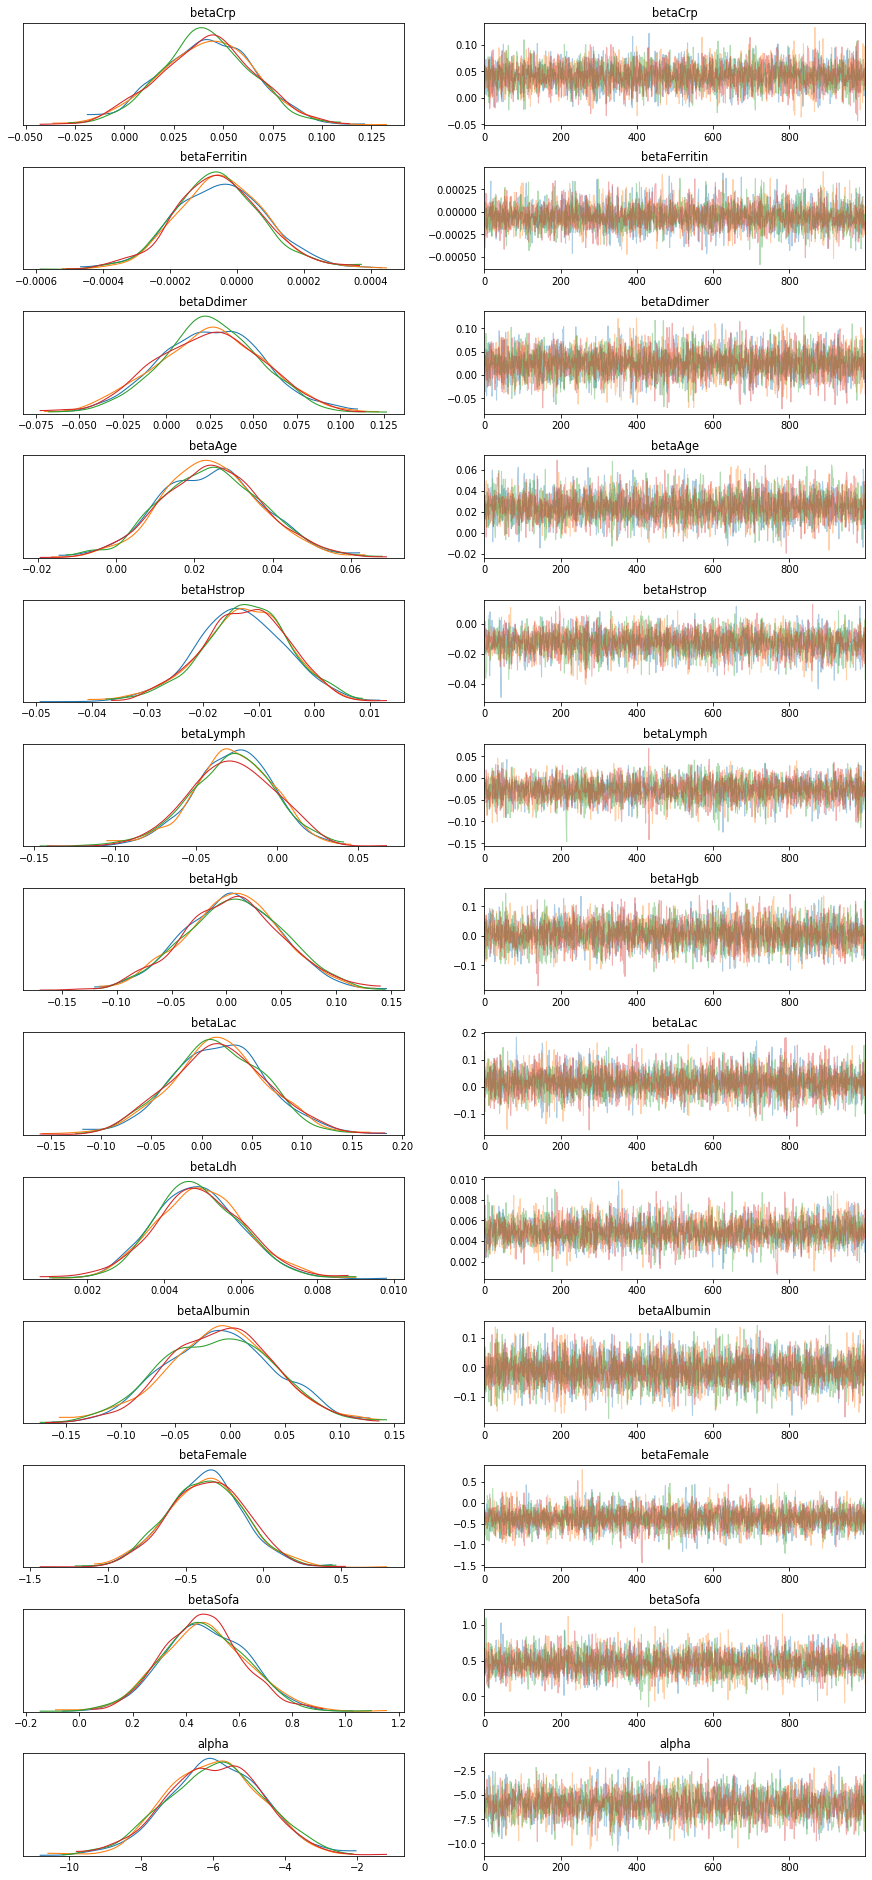

In [27]:
az.plot_trace(trace_ICU, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                    'betaFemale', 'betaSofa', 'alpha'])

In [28]:
outputDF = pd.DataFrame({'predictedProb' : modelData.posteriorProbabilities, 'icu' : modelData.icu})
outputDF['icuDecile'] = pd.qcut(outputDF.predictedProb, 10)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


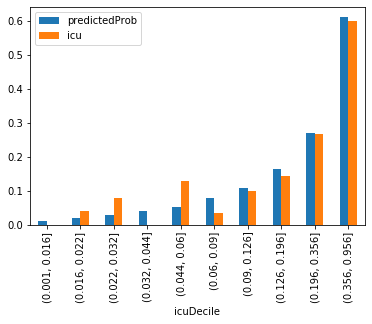

In [29]:
from datetime import date


# calibration looks perfectly decent.
outputDF.groupby('icuDecile').mean().plot.bar()
plt.savefig(f'calibration{str(date.today())}.eps')

In [57]:
modelCoefficients = az.summary(trace_ICU, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                      'betaFemale', 'betaSofa', 'alpha'])[['mean', 'sd']]
modelCoefficients.rename(columns={'mean': 'beta', 'sd':'sdBeta'}, inplace=True)
for key, value in ninetyMinusTenForLab.items():
    modelCoefficients.loc[(modelCoefficients.index == getBetaNameForLab(key)),'priority'] = np.abs(value)
    modelCoefficients.loc[(modelCoefficients.index == getBetaNameForLab(key)),'p50'] = modelData[key].quantile(0.50)
    
for i, row in modelCoefficients.iterrows():
    if row.name[0:4] == 'beta':
        modelCoefficients.loc[modelCoefficients.index==row.name, 'name'] = row.name[4:].lower()
    else:
        modelCoefficients.loc[modelCoefficients.index==row.name, 'name'] = row.name



betaCrp
betaFerritin
betaDdimer
betaAge
betaHstrop
betaLymph
betaHgb
betaLac
betaLdh
betaAlbumin
betaFemale
betaSofa
alpha


In [58]:
modelCoefficients

,beta,sdBeta,priority,p50,name
betaCrp,0.041,0.024,0.062953,7.00,crp
betaFerritin,-0.000,0.000,0.010831,615.70,ferritin
betaDdimer,0.025,0.030,0.012512,0.82,ddimer
betaAge,0.025,0.013,NaN,NaN,age
betaHstrop,-0.013,0.008,0.064847,13.00,hstrop
betaLymph,-0.028,0.025,NaN,NaN,lymph
betaHgb,0.006,0.045,0.002920,13.80,hgb
betaLac,0.017,0.048,0.001801,1.40,lac
betaLdh,0.005,0.001,0.129439,377.00,ldh
betaAlbumin,-0.009,0.050,0.000010,4.20,albumin


In [59]:
modelCoefficients.to_stata(f'icuAdmitCoeffs-{str(date.today())}.dta')
modelData.to_stata(f'modelData-{str(date.today())}.dta')

In [60]:
modelCoefficients.to_dict()

{'beta': {'betaCrp': 0.041,
  'betaFerritin': -0.0,
  'betaDdimer': 0.025,
  'betaAge': 0.025,
  'betaHstrop': -0.013,
  'betaLymph': -0.028,
  'betaHgb': 0.006,
  'betaLac': 0.017,
  'betaLdh': 0.005,
  'betaAlbumin': -0.009,
  'betaFemale': -0.37,
  'betaSofa': 0.469,
  'alpha': -5.945},
 'sdBeta': {'betaCrp': 0.024,
  'betaFerritin': 0.0,
  'betaDdimer': 0.03,
  'betaAge': 0.013,
  'betaHstrop': 0.008,
  'betaLymph': 0.025,
  'betaHgb': 0.045,
  'betaLac': 0.048,
  'betaLdh': 0.001,
  'betaAlbumin': 0.05,
  'betaFemale': 0.249,
  'betaSofa': 0.156,
  'alpha': 1.327},
 'priority': {'betaCrp': 0.062953488372093,
  'betaFerritin': 0.010830564784053254,
  'betaDdimer': 0.012511627906976713,
  'betaAge': nan,
  'betaHstrop': 0.06484717607973423,
  'betaLymph': nan,
  'betaHgb': 0.002920265780730874,
  'betaLac': 0.0018006644518272497,
  'betaLdh': 0.1294385382059801,
  'betaAlbumin': 9.96677740855434e-06,
  'betaFemale': nan,
  'betaSofa': nan,
  'alpha': nan},
 'p50': {'betaCrp': 7.0,
 

In [ ]:
# there is a fairly reasonable agreement between our baseline bayesian model and a default-tuned elastic net
# that seesm liek a decent argument that our pessimism was calibrated reasonably...

In [ ]:
from glmnet import LogitNet

m = LogitNet()
m = m.fit(modelData.loc[:,modelData.columns != 'icu'], modelData.icu)

In [ ]:
m.coef_